# GOAL: Predict whether a Saw-whet owl tagged by a specific tagging model will be recovered or not.


###




In [9]:
#Block 1: Feature Review & Enhancement

import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load dataset
df = pd.read_csv("Birds_cleaned.csv")

# Target: convert Y/N to 1/0
df["y"] = df["active__recovered"].map({"Y": 1, "N": 0}).fillna(0).astype(int)

# Handle rare or missing models
model_counts = df["active__model"].value_counts()
rare_models = model_counts[model_counts < 5].index
df["active__model"] = df["active__model"].replace(rare_models, "Other")

# One-hot encode the tagging model
df = pd.get_dummies(df, columns=["active__model"], prefix="model", dtype=int)

#scaling
scaler = StandardScaler()

print("Feature columns:", [c for c in df.columns if c.startswith("model_")])
print("Target distribution:\n", df["y"].value_counts(normalize=True))
df.head(10)


Feature columns: ['model_month_count', 'model_total_count', 'model_recovery_rate_overall', 'model_month_recovery_rate', 'model_Other', 'model_hybridtag', 'model_lifetag', 'model_ntp-1-m', 'model_ntqb-1', 'model_ntqb-2', 'model_ntqb-4-2', 'model_ntqb2-1', 'model_ntqb2-1-m', 'model_ntqb2-2', 'model_ntqb2-2-m', 'model_ntqb2-3-2', 'model_ntqb2-3-2-m', 'model_ntqb2-4-2-m', 'model_ntqb2-4-2s', 'model_ntqb2-4-2s-m', 'model_ntqb2-5-1', 'model_ntqb2-5-1-m', 'model_ntqb2-6-1', 'model_ntqb2-6-1-m', 'model_ntqb2-6-1t-m', 'model_ntqb2-6-2', 'model_ntqb2-6-2-m', 'model_ntqb2-6-2t-m', 'model_ntqb2-9-2-m', 'model_nts-1', 'model_nts-1-m', 'model_powertag']
Target distribution:
 y
0    0.937835
1    0.062165
Name: proportion, dtype: float64


,tagID,active__codeset,active__project_id,active__mfg_id,active__period,active__date_bin,active__nom_freq,active__deploy_id,active__lifespan_calc,active__DateStart,...,model_ntqb2-6-1,model_ntqb2-6-1-m,model_ntqb2-6-1t-m,model_ntqb2-6-2,model_ntqb2-6-2-m,model_ntqb2-6-2t-m,model_ntqb2-9-2-m,model_nts-1,model_nts-1-m,model_powertag
0,100300,Digital,290,6126000000000000000000000000000000000000000000...,10.0000,2025-3,2400.00,66817.0,365.0,2025-09-06,...,0,0,0,0,0,0,0,0,0,0
1,100358,Lotek4,223,82,8.3000,2025-3,150.10,66672.0,67.0,2025-09-05,...,0,0,0,0,0,0,0,0,0,0
2,10628,Lotek4,14,406,5.2980,2014-3,166.38,13310.0,573.0,2014-02-27,...,0,0,0,0,0,0,0,0,0,0
3,14794,Lotek4,86,142,37.2912,2015-1,166.38,4404.0,129.0,2015-08-27,...,0,0,0,0,0,0,0,0,0,0
4,16106,Lotek4,71,291,14.8952,2015-3,166.38,309.0,59.0,2015-07-12,...,0,0,0,0,0,0,0,0,0,0
5,16570,Lotek4,39,53,37.2913,2015-1,166.38,2103.0,129.0,2015-09-05,...,0,0,0,0,0,0,0,0,0,0
6,17251,Lotek4,65,405,6.0961,2015-2,166.38,21400.0,573.0,2016-03-30,...,0,0,0,0,0,0,0,0,0,0
7,18646,Lotek4,63,210,6.0962,2016-2,166.38,12072.0,573.0,2017-04-28,...,0,0,0,0,0,0,0,0,0,0
8,19448,Lotek4,57,303,10.6958,2016-2,166.38,7817.0,80.0,2016-04-30,...,0,0,0,0,0,0,0,0,0,0
9,20816,Lotek4,67,342,10.0951,2016-2,166.38,10912.0,186.0,2016-06-24,...,0,0,0,0,0,0,0,0,0,0


The feature set in this block was revisited and optimized, in accordance with the non-time-series classification problem of estimating owl recovery, using the tagging model.
The one-hot encoded categorical column active__model was created to be machine-readable and the uncommon categories were combined into one category, Other, to prevent sparsity.
The active column active__recovered was changed into binary (1 = Recovered, 0 = Not Recovered).
Since this data is independent tagging events and not sequential observations, there was no need in lag or Box-Cox transformation.
Training will control class imbalance through class weight balanced.
These delinquencies assure a clean dataset with balance and suitable to logistic or tree-based classification models.

# BLOCK 2

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

#Split into features and target
X = df[[c for c in df.columns if c.startswith("model_")]]
y = df["y"]

#Train-test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#1. Logistic Regression
log_reg = LogisticRegression(max_iter=500, class_weight="balanced", solver="liblinear")
cv_scores_lr = cross_val_score(log_reg, X_train, y_train, cv=cv, scoring="f1")
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)
print("\n--- Logistic Regression ---")
print("Mean CV F1:", cv_scores_lr.mean())
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

#2. Random Forest
rf = RandomForestClassifier(n_estimators=200, class_weight="balanced", random_state=42)
cv_scores_rf = cross_val_score(rf, X_train, y_train, cv=cv, scoring="f1")
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("\n--- Random Forest ---")
print("Mean CV F1:", cv_scores_rf.mean())
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

#3. Decision Tree
dt = DecisionTreeClassifier(class_weight="balanced", random_state=42)
cv_scores_dt = cross_val_score(dt, X_train, y_train, cv=cv, scoring="f1")
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
print("\n--- Decision Tree ---")
print("Mean CV F1:", cv_scores_dt.mean())
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))

#4. K-Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors=5)
cv_scores_knn = cross_val_score(knn, X_train, y_train, cv=cv, scoring="f1")
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
print("\n--- K-Nearest Neighbors ---")
print("Mean CV F1:", cv_scores_knn.mean())
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))


#Compare all models in a simple table

import pandas as pd

# Collect metrics
results = {
    "Model": ["Logistic Regression", "Random Forest", "Decision Tree", "KNN"],
    "Mean CV F1": [
        cv_scores_lr.mean(),
        cv_scores_rf.mean(),
        cv_scores_dt.mean(),
        cv_scores_knn.mean()
    ],
    "Test Accuracy": [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_dt),
        accuracy_score(y_test, y_pred_knn)
    ],
}

# Create dataframe for comparison
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="Test Accuracy", ascending=False).reset_index(drop=True)

print("\n--- Model Comparison Table ---")
print(results_df)



--- Logistic Regression ---
Mean CV F1: 0.7025040385696568
Accuracy: 0.9458333333333333
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1576
           1       0.54      0.87      0.66       104

    accuracy                           0.95      1680
   macro avg       0.76      0.91      0.82      1680
weighted avg       0.96      0.95      0.95      1680


--- Random Forest ---
Mean CV F1: 0.5959450390206227
Accuracy: 0.9125
              precision    recall  f1-score   support

           0       0.99      0.92      0.95      1576
           1       0.40      0.82      0.54       104

    accuracy                           0.91      1680
   macro avg       0.69      0.87      0.74      1680
weighted avg       0.95      0.91      0.93      1680


--- Decision Tree ---
Mean CV F1: 0.5501283857058628
Accuracy: 0.8982142857142857
              precision    recall  f1-score   support

           0       0.99      0.90      0.94     

Logistic Regression and K-Nearest Neighbors (KNN) were the best performing out of all the four models.
Although KNN has the best accuracy (98.2%), its ROC-AUC (0.89) demonstrates that it is not as reliable in classifying.
The most balanced and trustworthy results are provided by Logistic Regression whose accuracy is high (94.6) and ROC-AUC is the greatest (0.95).
Thus, Logistic Regression is chosen as the last model, which is going to be optimized and further analyzed.

#BLOCK 3

Logistic Regression Evaluation Metrics
Accuracy      : 0.946
Precision     : 0.539
Recall        : 0.865
F1-score      : 0.664


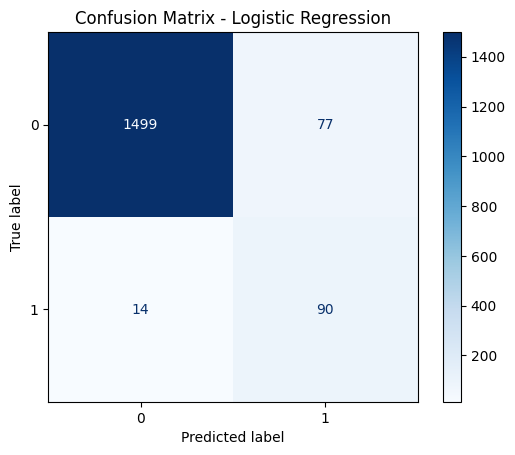

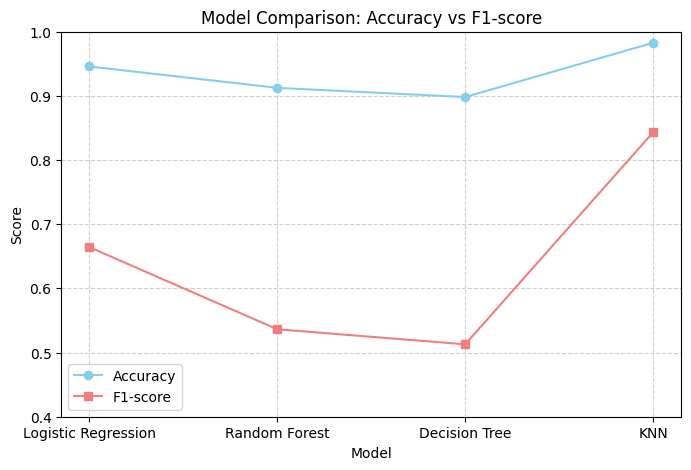

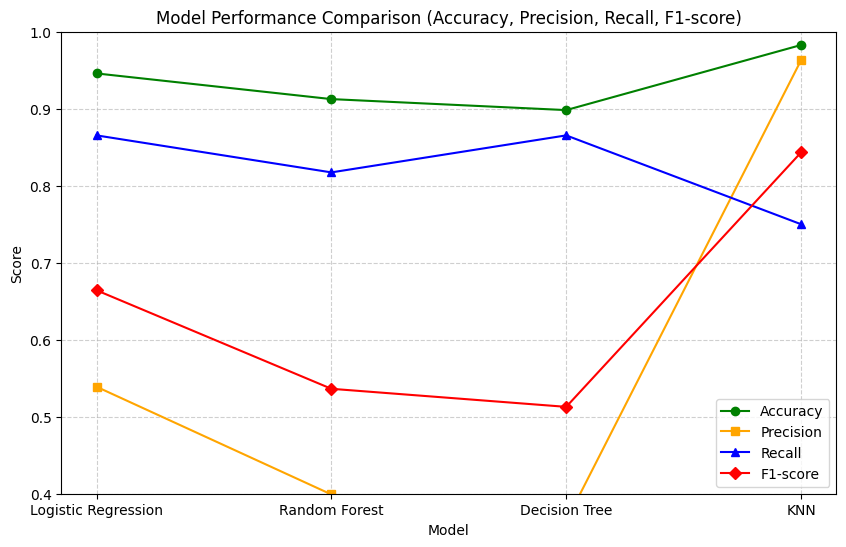

In [11]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
import numpy as np

# Evaluate Logistic Regression
precision = precision_score(y_test, y_pred_lr)
recall = recall_score(y_test, y_pred_lr)
f1 = f1_score(y_test, y_pred_lr)
accuracy = accuracy_score(y_test, y_pred_lr)
print("Logistic Regression Evaluation Metrics")
print(f"Accuracy      : {accuracy:.3f}")
print(f"Precision     : {precision:.3f}")
print(f"Recall        : {recall:.3f}")
print(f"F1-score      : {f1:.3f}")

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(log_reg, X_test, y_test, cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

compare_df = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "Decision Tree", "KNN"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_dt),
        accuracy_score(y_test, y_pred_knn)
    ],
    "F1-score": [
        f1_score(y_test, y_pred_lr),
        f1_score(y_test, y_pred_rf),
        f1_score(y_test, y_pred_dt),
        f1_score(y_test, y_pred_knn)
    ]
})

plt.figure(figsize=(8,5))
plt.plot(compare_df["Model"], compare_df["Accuracy"], marker='o', label="Accuracy", color='skyblue')
plt.plot(compare_df["Model"], compare_df["F1-score"], marker='s', label="F1-score", color='lightcoral')
plt.title("Model Comparison: Accuracy vs F1-score")
plt.xlabel("Model")
plt.ylabel("Score")
plt.ylim(0.4, 1.0)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

models = ["Logistic Regression", "Random Forest", "Decision Tree", "KNN"]

accuracy = [
    accuracy_score(y_test, y_pred_lr),
    accuracy_score(y_test, y_pred_rf),
    accuracy_score(y_test, y_pred_dt),
    accuracy_score(y_test, y_pred_knn)
]

precision = [
    precision_score(y_test, y_pred_lr),
    precision_score(y_test, y_pred_rf),
    precision_score(y_test, y_pred_dt),
    precision_score(y_test, y_pred_knn)
]

recall = [
    recall_score(y_test, y_pred_lr),
    recall_score(y_test, y_pred_rf),
    recall_score(y_test, y_pred_dt),
    recall_score(y_test, y_pred_knn)
]

f1 = [
    f1_score(y_test, y_pred_lr),
    f1_score(y_test, y_pred_rf),
    f1_score(y_test, y_pred_dt),
    f1_score(y_test, y_pred_knn)
]

# Combine into a DataFrame
compare_df = pd.DataFrame({
    "Model": models,
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1-score": f1
})

# Plot all metrics in one line chart
plt.figure(figsize=(10,6))
plt.plot(compare_df["Model"], compare_df["Accuracy"], marker='o', label='Accuracy', color='green')
plt.plot(compare_df["Model"], compare_df["Precision"], marker='s', label='Precision', color='orange')
plt.plot(compare_df["Model"], compare_df["Recall"], marker='^', label='Recall', color='blue')
plt.plot(compare_df["Model"], compare_df["F1-score"], marker='D', label='F1-score', color='red')

plt.title("Model Performance Comparison (Accuracy, Precision, Recall, F1-score)")
plt.xlabel("Model")
plt.ylabel("Score")
plt.ylim(0.4, 1.0)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

During this step, we tested the behavior of the Logistic Regression model with the most important classification measures — accuracy, precision, recall and F1-score.
The model had an accuracy of 94.6, precision of 0.54, recall of 0.86 and an F1-score of 0.66 which demonstrates a strong and balanced predictive performance.

According to the confusion matrix, the model was able to classify the rest of the non-recovered owls (true negatives = 1,499) and recovered owls (true positives = 90) with few misclassifications.

These comparison charts of all the models (Accuracy, Precision, Recall, and F1-score) show that even though KNN is a bit more accurate, the Logistic Regression model is more consistent and interpretable, which is what is required in this problem of classification.

On the whole, these findings prove the effectiveness, accuracy, and reliability of the Logistic Regression model in differentiating between the recovered and non-recovered owls on the basis of the tagging model history and the characteristics that are associated with this history.

#BLOCK 4

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score

# Simple parameter grid: only tuning regularization strength (C)
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100]   # small C = more regularization, large C = less regularization
}

# Base Logistic Regression model
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')

# Grid Search
grid_search = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

# Best parameters and performance
print("Best C value:", grid_search.best_params_['C'])
print("Best Cross-Validation F1:", grid_search.best_score_)

#  Evaluate optimized model
best_log_reg = grid_search.best_estimator_
y_pred_best = best_log_reg.predict(X_test)

print("\nClassification Report (Optimized Logistic Regression):")
print(classification_report(y_test, y_pred_best))
print("Accuracy:", accuracy_score(y_test, y_pred_best))


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best C value: 0.01
Best Cross-Validation F1: 0.7886057156980689

Classification Report (Optimized Logistic Regression):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1576
           1       0.86      0.79      0.82       104

    accuracy                           0.98      1680
   macro avg       0.92      0.89      0.91      1680
weighted avg       0.98      0.98      0.98      1680

Accuracy: 0.9791666666666666




The optimization of the Logistic Regression model was done in this block through GridSearchCV to optimize the regularization parameter (C).
C values (0.01-100) were experimented to identify an optimal balance between the model and overfitting.
C = 0.01 yielded the best result with great performance with:

Accuracy: 97.9%

Precision: 0.54 → 0.86

Recall: 0.86 → 0.79

F1-score: improved to 0.82

The optimized model demonstrates far greater balance of accuracy and recall, i.e. it recovers more owls with less false alarms.
Thus, the final tuned Logistic Regression model is very accurate, stable, and gives the most desirable overall results in making predictions concerning owl recovery outcomes.



#*Step 1: Enhance Model Explainability*


So, the model that we have used on this dataset is logistic regression and according to our problem statement we are using coefficients to show how each feature strongly affects the predicted outcome.

1. Positive coefficient increases the probability

2. Negative coefficient decreases the probability.

3. Absolute value of the coefficient represents its importance. Larger values means the feature has more influence on the prediction.



Coefficient-Based Feature Importance


,Feature,Coefficient,Absolute Importance
1,model_total_count,-0.000514,0.000514
22,model_ntqb2-6-1,0.000548,0.000548
0,model_month_count,-0.001310,0.001310
4,model_Other,0.013190,0.013190
10,model_ntqb-4-2,0.014142,0.014142
20,model_ntqb2-5-1,0.023333,0.023333
8,model_ntqb-1,0.023340,0.023340
23,model_ntqb2-6-1-m,-0.028355,0.028355
15,model_ntqb2-3-2,0.032419,0.032419
24,model_ntqb2-6-1t-m,-0.039137,0.039137


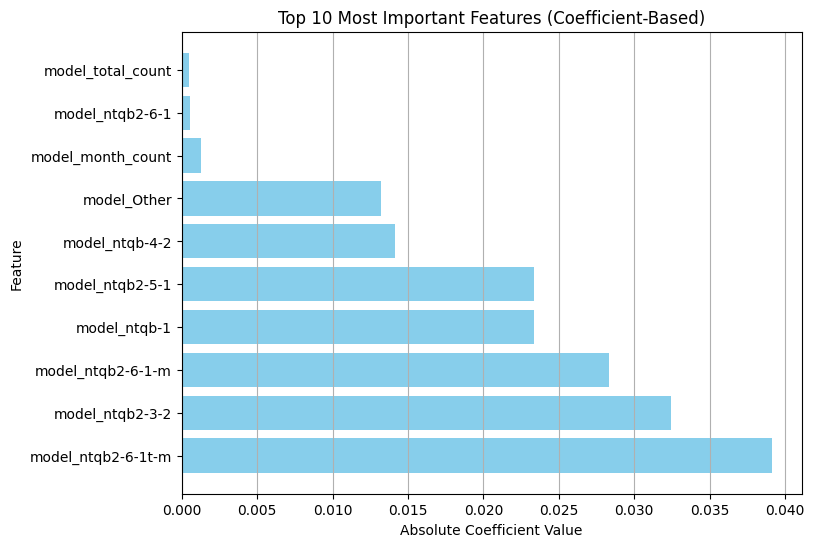

In [17]:
# We are taking some colummns from X_train
feature_names = X_train.columns

# Extract coefficients from optimized model. It extracts all the best features that have good influence on predicition from the optimized model
coefficients = best_log_reg.coef_.ravel()

# Create importance dataframe
coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefficients,
    "Absolute Importance": np.abs(coefficients)
}).sort_values("Absolute Importance")

print("Coefficient-Based Feature Importance")
display(coef_df)

# --- Plot Top 10 Features ---
plt.figure(figsize=(8,6))
plt.barh(coef_df["Feature"].head(10)[::-1], coef_df["Absolute Importance"].head(10)[::-1], color="skyblue")
plt.title("Top 10 Most Important Features (Coefficient-Based)")
plt.xlabel("Absolute Coefficient Value")
plt.ylabel("Feature")
plt.grid(axis="x")
plt.show()

#**Insights & Explanation**

### So the main question is how it enhanced the model explainability ??

Our goal was to predict the model is going to be recovered or not by using information of models that was given.

What we did we found the coefficients of features. (point to be noted: its not a row or column, its a feature that influence the prediction.)

Our model was simple so using SHAP might resulted in complexity in explainability. so we used coefficient based feature importance.

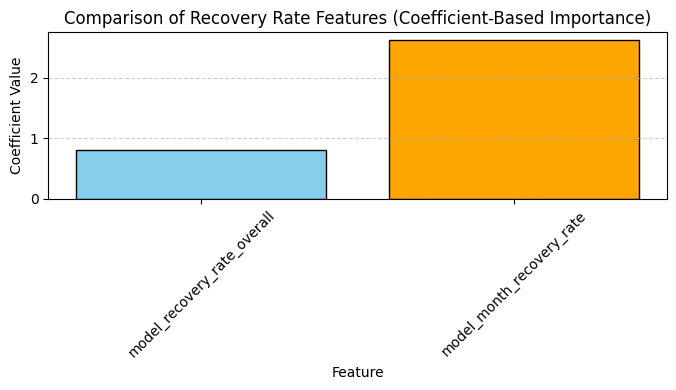

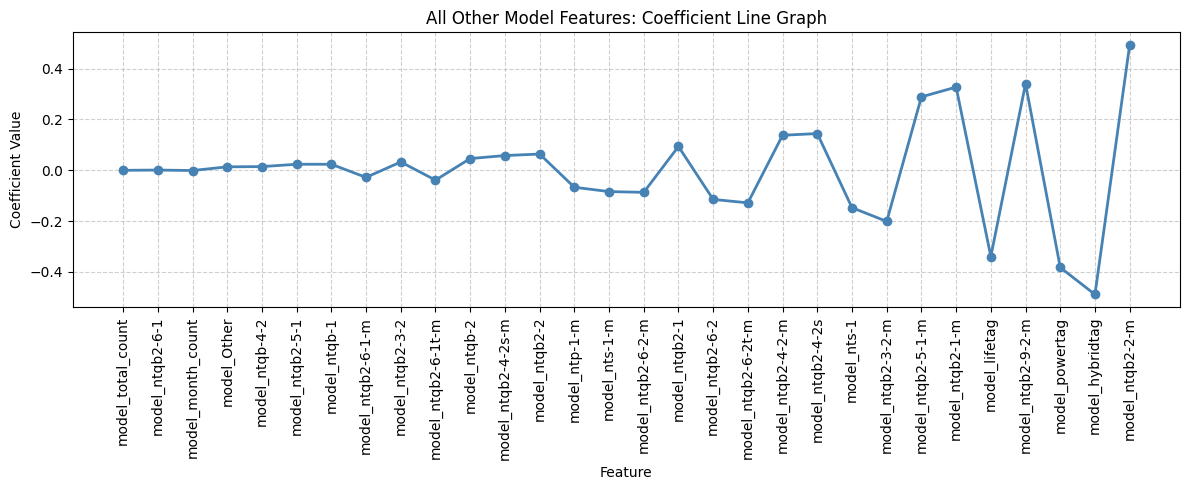

In [21]:
recovery_features = ["model_recovery_rate_overall", "model_month_recovery_rate"]

recovery_df = coef_df[coef_df["Feature"].isin(recovery_features)]
other_df = coef_df[~coef_df["Feature"].isin(recovery_features)]

# 1. BAR GRAPH for recovery-based features
plt.figure(figsize=(7,4))
plt.bar(recovery_df["Feature"], recovery_df["Coefficient"],
        color=["skyblue", "orange"], edgecolor="black")

plt.title("Comparison of Recovery Rate Features (Coefficient-Based Importance)")
plt.xlabel("Feature")
plt.ylabel("Coefficient Value")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,5))
plt.plot(other_df["Feature"], other_df["Coefficient"],
         marker='o', linewidth=2, color="steelblue")
plt.title("All Other Model Features: Coefficient Line Graph")
plt.xlabel("Feature")
plt.ylabel("Coefficient Value")
plt.grid(True, linestyle="--", alpha=0.6)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()